In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND'] = 'theano'
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    return string.strip().lower()

In [3]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
df = pd.read_csv("cyber_tweets.csv",encoding = "ISO-8859-1")
df = df.dropna()
df = df.reset_index(drop=True)

print('Shape of dataset ',df.shape)
print('No. of unique annotation',len(set(df['annotation'])))
print(df.columns)
df.head()

Shape of dataset  (21487, 4)
No. of unique annotation 4
Index(['id', 'text', 'annotation', 'type'], dtype='object')


,id,text,annotation,type
0,5b88752abb325e65390af240,Best way to build empathy is through honesty a...,irrelevant,['vulnerability']
1,5b8875d5bb325e65a22cf81b,Cryptocurrency Scams Replacing Ransomware as A...,business,['ransomware']
2,5b88768dbb325e65fa7e78e3,Cryptocurrency Scams Replacing Ransomware as A...,business,['ransomware']
3,5b8876f9bb325e65fa7e78e4,Protect your customers access Prestashop Ant...,threat,['ddos']
4,5b8876f9bb325e65fa7e78e5,Data leak from Huazhu Hotels may affect 130 mi...,threat,['leak']


In [5]:
macronum=sorted(set(df['annotation']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['annotation']=df['annotation'].apply(fun)

In [6]:
texts = []
labels = []


for idx in range(df.text.shape[0]):
    text = BeautifulSoup(df.text[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['annotation']:
    labels.append(idx)

C:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 54141


In [8]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (21487, 1000)
Shape of Label Tensor: (21487, 4)


In [9]:
embeddings_index = {}
f = open('glove.twitter.27B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1193514 word vectors in Glove 6B 100d.


In [10]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [14]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='sigmoid')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         5414200   
                                                                 
 conv1d_6 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 39, 128)          0         
 1D)               

In [21]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=128)

Epoch 1/15
135/135 [==============================] - 106s 788ms/step - loss: 0.1649 - acc: 0.9301 - val_loss: 1.4611 - val_acc: 0.6539
Epoch 2/15
135/135 [==============================] - 104s 770ms/step - loss: 0.1640 - acc: 0.9286 - val_loss: 1.6829 - val_acc: 0.6502
Epoch 3/15
135/135 [==============================] - 107s 796ms/step - loss: 0.1570 - acc: 0.9318 - val_loss: 1.5443 - val_acc: 0.6584
Epoch 4/15
135/135 [==============================] - 105s 778ms/step - loss: 0.1542 - acc: 0.9336 - val_loss: 1.5614 - val_acc: 0.6393
Epoch 5/15
135/135 [==============================] - 101s 745ms/step - loss: 0.1505 - acc: 0.9333 - val_loss: 1.6392 - val_acc: 0.6551
Epoch 6/15
135/135 [==============================] - 105s 781ms/step - loss: 0.1517 - acc: 0.9332 - val_loss: 1.7214 - val_acc: 0.6665
Epoch 7/15
135/135 [==============================] - 105s 779ms/step - loss: 0.1477 - acc: 0.9359 - val_loss: 1.6066 - val_acc: 0.6579
Epoch 8/15
135/135 [============================

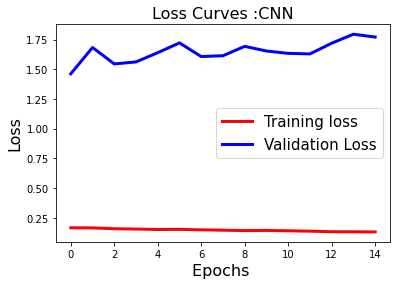

In [22]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=15)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

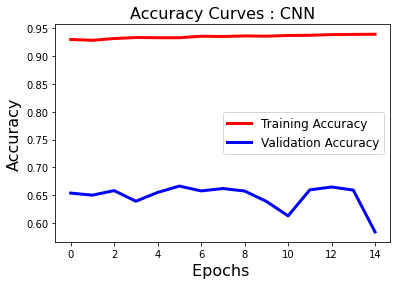

In [23]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()